# Topic 38: Time Series Models

https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/

* AR model (autoregression)
* MA model (moving average)
* ARMA model (autoregression + moving average)
* Differencing model
* ARIMA model (autoregression + differencing + moving average)
* SARIMA model (seasonal ARIMA)
* ARIMAX model (ARIMA + exogenous variables)
* SARIMAX model (seasonal ARIMA + exogenous variables)

## Auto-regressive Time Series Model

An autoregression model makes an assumption that the observations at previous time steps are useful to predict the value at the next time step. It is one of the simplest time series models in which we use a linear model to predict the value at the present time using the value at the previous time. 

<p style='text-align:center; font-size: 30px;'>𝑌<sub>t</sub>=𝜙<sub>1</sub>𝑌<sub>𝑡−1</sub>+𝜖<sub>𝑡</sub></p>

The numeral one (1) denotes that the next instance is solely dependent on the previous instance.  The 𝜙(phi) is a coefficient which we seek so as to minimize the error function.

The order of AR is the number of lag terms we are using to predict the present value (AR(1) uses only 1 lag - one value directly preceding the value you are trying to predict, AR(2) use the two values directly preceding the value you are trying to predict) 

#### How do we determine the order aka how many lag terms do we include? 

Using ACF and PACF! 


<img src='../resources/AR(1).png'>

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

# Load Data and Process Data

<AxesSubplot:xlabel='Month'>

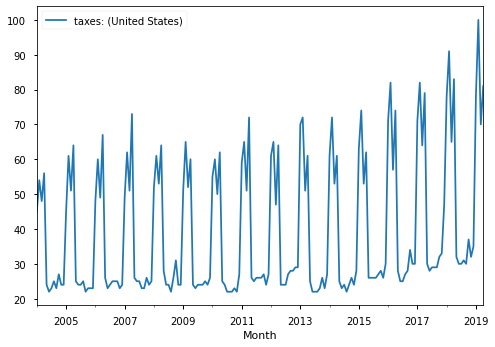

In [22]:
#read in csv
taxes = pd.read_csv('../resources/google-trends_taxes_us.csv', header=1).iloc[:-1]

#set index to datetime and set frequency to Month Start ('MS')
taxes['Month'] = pd.to_datetime(taxes['Month'], infer_datetime_format=True)
taxes = taxes.set_index('Month')
taxes.index.freq = 'MS'

#plot of data to see visualize trends
taxes.plot()

Nope.  Do you remember what we did in the last class to make it stationary?

We logged it to help remove the trend and changing covariance, took a 12 month difference to remove seasonality, and took another difference of 1 month.

## Making Data Stationary

In [23]:
adfuller(taxes)

(0.9891104732557353,
 0.9941497122029829,
 12,
 171,
 {'1%': -3.4691814633722453,
  '5%': -2.878595143532943,
  '10%': -2.5758625549741803},
 907.6355457129328)

In [24]:
stationary_taxes = np.log(taxes).diff().diff()
stationary_taxes = stationary_taxes.dropna()
adfuller(stationary_taxes)

(-12.036104490022943,
 2.8009651672554794e-22,
 13,
 168,
 {'1%': -3.4698858990744115,
  '5%': -2.8789026251889647,
  '10%': -2.5760266680839004},
 -335.00671254247845)

# Train-Test Split for Time Series

When dividing your time series data for training and testing, we don't split it randomly like for some other kinds of modeling.  

Why Not?


*YOUR ANSWER HERE*

In [25]:
# train-test-split for time series isn't random!
split = int(len(taxes) * .9)
full_train, holdout = stationary_taxes.iloc[:split], stationary_taxes.iloc[split:]

second_split = int(len(full_train) * .9)
train, test = full_train[:second_split], full_train[second_split:]

### AR(1) Model

What's going on below?  We have ARIMA(order=(1,0,0)).fit()

First off, we are going to learn about MA, or moving average, models next.  The I denotes differencing that the model will perform (in case we didn't do it ourselves) to make the data stationary, and is called the Integrated component.

AR(auto-regressive)

I(Integrated)

MA(moving average)

ARIMA is a combination model, or an ARMA model with differencing.

The 'order' argument tells the ARIMA model which lags to include in the model and many times to difference it.
Order is often represented as (p,d,q)

p = lags used in the AR part

d = order of differencing to perform

q = lags to use in the MA part.

In the model below we will use (1,0,0) which is equivalent to just auto-regressive model only using 1 lag.

In [26]:
# define a function to evaluate our models for us.
def evaluate_model(model, data, train, test, train_predict_start=0):
    """
    Takes a fitted ARIMA model, the original data, the train split and the test split.
    optionally, can take a training starting point between 0 and len(train).  default = 0
    optionally, can take forecast length to determine how far to forecast
    shows a chart of data, train prediction, and test prediction
    prints the MSE of the training prediction and the testing prediction
    returns a summary object from model.summary()
    """
    trainpreds = model.predict()
    testpreds = model.forecast(len(test))

    ax = plt.subplot(111)
    trainpreds.name = 'training prediction'
    testpreds.name = 'testing prediction'
    trainpreds.plot(ax=ax)
    testpreds.plot(ax=ax)
    data.plot(ax=ax, color='Yellow')
    plt.legend()
    plt.show()

    training_MSE = mean_squared_error(train, trainpreds)**.5
    testing_MSE = mean_squared_error(test, testpreds)**.5
    print('Training RMSE = ', training_MSE)
    print('Testing RMSE = ', testing_MSE)
    
    return model.summary()

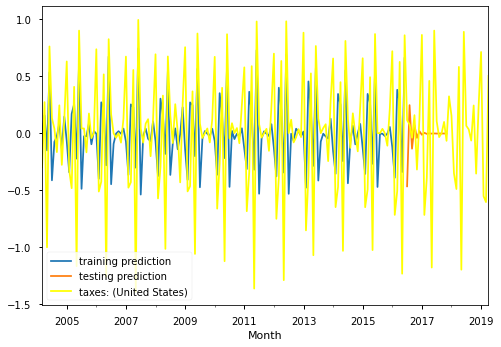

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:     taxes: (United States)   No. Observations:                  148
Model:                     ARIMA(1, 0, 0)   Log Likelihood                 -96.161
Date:                    Fri, 23 Jul 2021   AIC                            198.323
Time:                            14:55:45   BIC                            207.314
Sample:                        03-01-2004   HQIC                           201.976
                             - 06-01-2016                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0033      0.027     -0.121      0.903      -0.057       0.051
ar.L1         -0.5373      0.071     -7.594      0.000      -0.676      -0.399
sigma2         0.2142      0.028      7.601      0.000       0.159       0.269
===================================================================================
Ljung-Box (L1) (Q):                   5.75   Jarque-Bera (JB):                 5.20
Prob(Q):                              0.02   Prob(JB):                         0.07
Heteroskedasticity (H):               1.09   Skew:                            -0.45
Prob(H) (two-sided):                  0.76   Kurtosis:                         2.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Training RMSE =  0.4630363118841626
Testing RMSE =  0.505075511351096


In [27]:
# order = (p, d, q)
# p - autoregressive
# d - differences
# q - moving average


ar1 = ARIMA(train, order=(1,0,0)).fit()
evaluate_model(ar1, stationary_taxes, train, test)

#### Interpretation of AR(1) model

How did our model do?  Let's interpret:

The training preds are created by the `ar1.predict()` call.  This makes a prediction for each point in the data, based on the actual previous data.  So the prediction for time period k is used by regressing on the values for time points 0:k-1.

The testing preds are created by `ar1.forecast()`.  Forecast predicts values for time periods after the stopping point of the training set passed.  It returns a number of predictions equal to the value passed, so `ar1.forecast(len(test))` will make a forecast a number of months ahead equal to the size of the testing slice of the data.

What do you notice, visually comparing the actual data to the predictions?

*YOUR ANSWER HERE*

If we look at the coefficients:
const = intercept

ar.L1 = coefficient for the first lag

sigma2 = variance of the error term

### AR(2) Model

What is the difference between an AR(2) and an AR(1) model?  Write your answer below.

*YOUR ANSWER HERE*

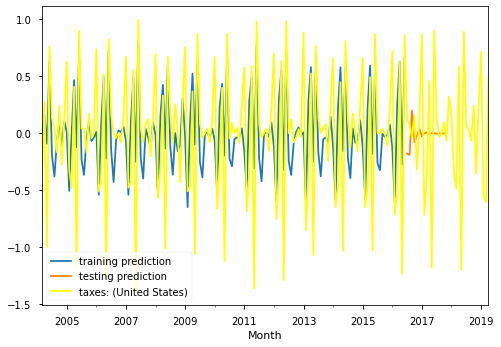

Training RMSE =  0.43119552459922
Testing RMSE =  0.501253083914602


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:     taxes: (United States)   No. Observations:                  148
Model:                     ARIMA(2, 0, 0)   Log Likelihood                 -85.722
Date:                    Fri, 23 Jul 2021   AIC                            179.445
Time:                            14:55:46   BIC                            191.433
Sample:                        03-01-2004   HQIC                           184.316
                             - 06-01-2016                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0029      0.020     -0.144      0.885      -0.042       0.036
ar.L1         -0.7277      0.137     -5.316      0.000      -0.996      -0.459
ar.L2         -0.3671      0.126     -2.919      0.004      -0.614      -0.121
sigma2         0.1857      0.022      8.491      0.000       0.143       0.229
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                12.36
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.08   Skew:                            -0.67
Prob(H) (two-sided):                  0.79   Kurtosis:                         3.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
ar2 = ARIMA(train, order=(2,0,0)).fit()
evaluate_model(ar2, stationary_taxes, train, test)

#### Interpretation of AR(2) model

Did we do better?  The training predictions were a little better, but we still don't realy have a great model yet.

## Moving Average Time Series Model

Sometimes, a past value is not a useful indicator of what value will come next. Consider a system that is subject to a lot of shocks/volatility. If a previous time period experiences a shock it may cause an error for future predictions if we just that value. A moving average model helps address this behavior. 

A moving average term in a time series model is a past error (multiplied by a coefficient).

An MA model assumes present value is related to errors in the past - includes memory of past errors


<p style='text-align: center; font-size:30px;'>𝑌<sub>t</sub>=μ + 𝜖<sub>𝑡</sub>+𝜃<sub>1</sub>𝜖<sub>𝑡−1</sub></p>

For more details on how this model is fit: https://365datascience.com/tutorials/time-series-analysis-tutorials/moving-average-model/

Note ARIMA(0,0,1) is equivalent to a MA(1) model because we are using 0 lags for AR and 0 order of differencing and using 1 lag for the moving average model.

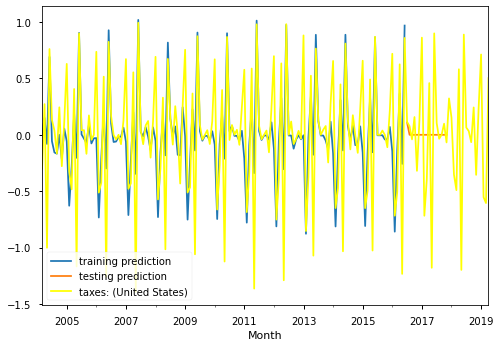

Training RMSE =  0.3830966953258248
Testing RMSE =  0.48478584394405627


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:     taxes: (United States)   No. Observations:                  148
Model:                     ARIMA(0, 0, 1)   Log Likelihood                 -68.154
Date:                    Fri, 23 Jul 2021   AIC                            142.308
Time:                            14:55:46   BIC                            151.300
Sample:                        03-01-2004   HQIC                           145.962
                             - 06-01-2016                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.535e-06      0.001     -0.002      0.999      -0.003       0.003
ma.L1         -0.9999     19.871     -0.050      0.960     -39.947      37.948
sigma2         0.1422      2.824      0.050      0.960      -5.393       5.677
===================================================================================
Ljung-Box (L1) (Q):                   0.47   Jarque-Bera (JB):                29.39
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                            -0.60
Prob(H) (two-sided):                  0.75   Kurtosis:                         4.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
ma1 = ARIMA(train, order=(0,0,1)).fit()
evaluate_model(ma1, stationary_taxes, train, test)

## Differencing Model aka Integrated Model

The differenced value is equal to the present value minus the value at the next lag. A time series which needs to be differenced to be made stationary is said to be an "integrated" time series.

<p>If d=0:  y<sub>t</sub>  =  Y<sub>t</sub></p>

If d=1:  y<sub>t</sub> =  Y<sub>t</sub> - Y<sub>t-1</sub>

If d=2:  y<sub>t</sub> =  (Y<sub>t</sub> - Y<sub>t-1</sub>) - (Y<sub>t-1</sub> - Y<sub>t-2</sub>)  =  Y<sub>t</sub> - 2Y<sub>t-1</sub> + Y<sub>t-2</sub>

## ARIMA

Combines AR, Differencing (I), and MA

The differenced value is equal to the present value minus the value at the next lag. A time series which needs to be differenced to be made stationary is said to be an "integrated" time series.

<p style ='text-align:center; font-size: 30px;'>𝑌<sub>t</sub>=𝜙<sub>1</sub>𝑌<sub>𝑡−1</sub>+𝜙<sub>2</sub>𝑌<sub>𝑡−2</sub>...𝜙<sub>𝑝</sub>𝑌<sub>t−𝑝</sub>+𝜖<sub>𝑡</sub>+𝜃<sub>1</sub>𝜖<sub>𝑡−1</sub>+𝜃<sub>2</sub>𝜖<sub>𝑡−2</sub>+...𝜃<sub>𝑞</sub>𝜖<sub>𝑡−𝑞</sub></p>



ARIMA has three main parameters we need to input, p, d, & q

<b>p:</b> The number of AR terms we are going to include<br/>
<b>d:</b> The number of times we are differencing our data<br/>
<b>q:</b> The number MA terms we are going to include

The ACF help us to find the right logs to use with the MA component of our model, or our `q` component.

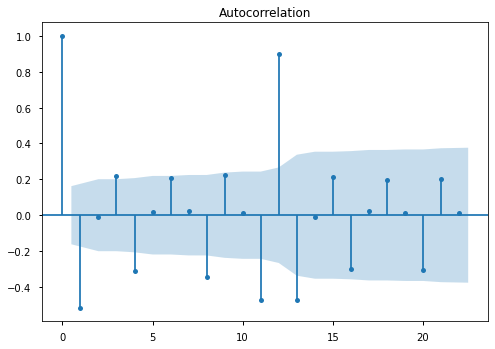

In [30]:
#ACF/PACF to determine which terms in include (MA or AR or Both?)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#take the log of the original taxes data, since we both logged and differenced to make our data stationary before.  
# ARIMA does not log the data for us.
log_taxes = np.log(taxes)

#remember we set 'split' to be .9 * len(taxes)
log_full_train, log_holdout = log_taxes[:split], log_taxes[split:]

# log_train, log_test = log_full_train[:second_split], log_full_train[second_split:]
log_train, log_test = log_full_train[:second_split], log_full_train[second_split:]

#plot autocorrelation for each lag (alpha is confidence interval).  We used the differenced data because we are looking 
# because we will difference it in the ARIMA model.  
plot_acf(log_train.diff().diff().dropna(), alpha=.05)
plt.show()

We use the PACF to determine logs for the AR part of the model, the `p` component.

/Users/josh/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


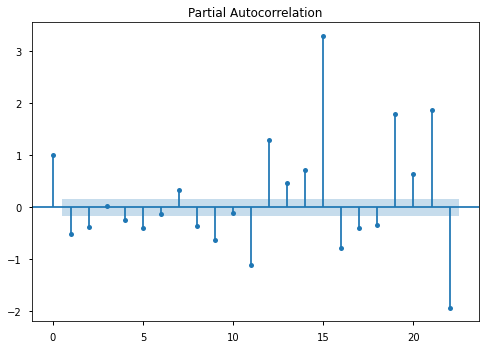

In [31]:
plot_pacf(log_train.diff().diff().dropna(), alpha=.05)
plt.show()

**Note**
The ARIMA model reverses the differencing in the predictions, so the predictions from an ARIMA model with `d=2` will return predictions on the same scale as the original data.  This is one of the benefits of this model type.

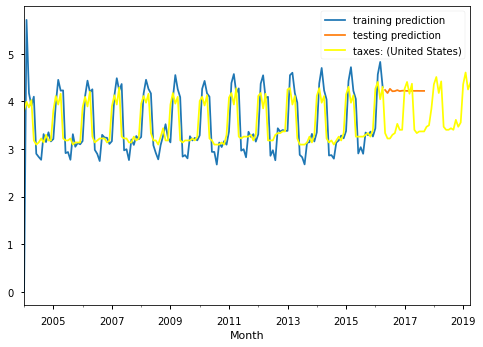

Training RMSE =  0.544435314079006
Testing RMSE =  0.7657706174836983


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:     taxes: (United States)   No. Observations:                  148
Model:                     ARIMA(2, 2, 1)   Log Likelihood                 -82.560
Date:                    Fri, 23 Jul 2021   AIC                            173.119
Time:                            14:55:46   BIC                            185.054
Sample:                        01-01-2004   HQIC                           177.969
                             - 04-01-2016                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9130      0.222     -4.105      0.000      -1.349      -0.477
ar.L2         -0.4750      0.135     -3.525      0.000      -0.739      -0.211
ma.L1          0.2382      0.348      0.685      0.493      -0.443       0.919
sigma2         0.1806      0.025      7.230      0.000       0.132       0.230
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 7.40
Prob(Q):                              0.87   Prob(JB):                         0.02
Heteroskedasticity (H):               1.05   Skew:                            -0.54
Prob(H) (two-sided):                  0.85   Kurtosis:                         3.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
from statsmodels.tsa.arima.model import ARIMA

arima1 = ARIMA(log_train, order=(2,2,1)).fit()

evaluate_model(arima1, log_taxes, log_train, log_test)

Examining the p-values for the lags tells us that many of the lags we included are not statistically relevant.  We can give an ARIMA model a tuple of lags, rather than just a integer.  An integer includes all lags up to the integer value.  A tuple only includes those lags in the tuple.  

Examining the coefficients above, which lags should we try including in our model next time?

*YOUR ANSWER HERE*

Even better, we could use a SARIMAX model to account for the seasonality in the data, rather than trying to figure out the right lags to fit on for them.  There is some information about SARIMAX models at the bottom of this notebook.

### Tuning P, D, and Q

In practice, we often need to tune p,d, and q using strategies similar to hyperparameter tuning in other models.  Often we try many different values and see which ones work best.  However ACF and PACF graphs help us make informed guesses rather than random ones.

## ARIMAX

ARIMA with eXogenous variables - extend ARIMA to include additional variables that might have an impact on what we are are trying to forecast. 

Considerations: 

1) Does our exogenous variable actually impact our endogenous variable (and not the other way around - use granger causality test) 

2) Exogenous variables need to be differenced at the same order as the endogenous 

### Endogenous Variables

So far we've only been using Endogenous variables.  Those are the variables that we trying to forecast, in this case the valume of searches for taxes on Google Search in the USA.

### Exogenous Variables

Exogenous Variables are extra variables outside of the data we are trying to predict.  These might be holidays or weekends, they might be search volumes for other terms, or anything else that can be aligned with the datetime period and are not endogenous.  



<img src='../resources/seasonal_data.png'/>

### SARIMAX

SARIMAX integrates the ARIMA model we've been using, as well as dealing more gracefully with (S)easonal trends and  e(X)ogenous variables.

You can read more about SARIMAX models below


https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

1. Plot data, see if there are trends <br/>
2. If trends, remove them (differencing, log transform, etc) <br/>
3. If seasonal trends are there determine periodicity. <br/>
4. ACF and PACF of  data <br/>
5. Determine order of differencing, AR, or MA (or both) <br/>
6. Build model and evaluate 


seasonal_order - (p,d,q,s)

s = periodicity of the seasonality, or how many periods between each season.

In our case, it's 12 periods, or 1 year.

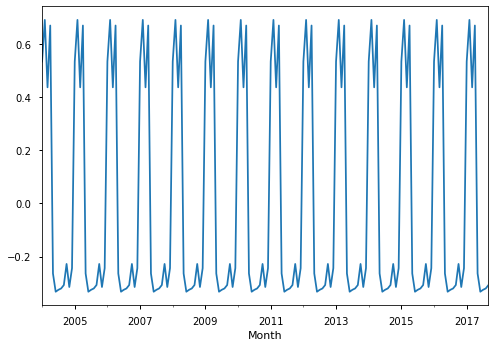

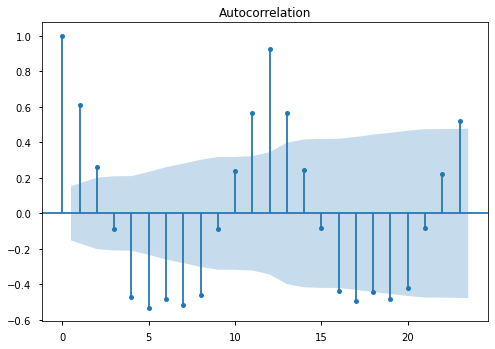

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(log_full_train)
res.seasonal.plot()
plt.show()
plot_acf(res.seasonal)
plt.show()

/Users/josh/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


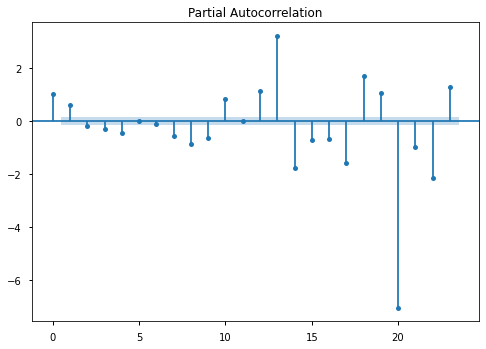

In [34]:
plot_pacf(res.seasonal)
plt.show()

Try the below SARIMAX model on your own.  What might be some exogenous variables you coudl use for this dataset?

/Users/josh/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/josh/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


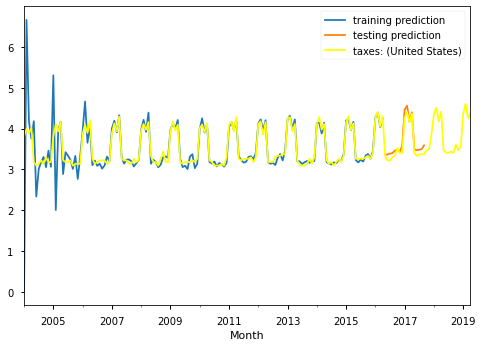

Training RMSE =  0.4646635914343755
Testing RMSE =  0.12751436590636844


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:             taxes: (United States)   No. Observations:                  148
Model:             SARIMAX(1, 2, 2)x(4, 2, 2, 12)   Log Likelihood                 131.514
Date:                            Fri, 23 Jul 2021   AIC                           -243.029
Time:                                    14:55:59   BIC                           -214.989
Sample:                                01-01-2004   HQIC                          -231.640
                                     - 04-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1193      0.238      0.502      0.616      -0.347       0.586
ma.L1         -1.4873      0.206     -7.233      0.000      -1.890      -1.084
ma.L2          0.5000      0.199      2.507      0.012       0.109       0.891
ar.S.L12      -1.0716      0.602     -1.779      0.075      -2.252       0.109
ar.S.L24      -0.6305      0.288     -2.187      0.029      -1.196      -0.065
ar.S.L36      -0.5237      0.218     -2.399      0.016      -0.952      -0.096
ar.S.L48      -0.3034      0.133     -2.282      0.023      -0.564      -0.043
ma.S.L12      -0.3806     18.073     -0.021      0.983     -35.802      35.041
ma.S.L24      -0.6148     11.545     -0.053      0.958     -23.243      22.013
sigma2         0.0041      0.075      0.055      0.956      -0.142       0.150
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 1.27
Prob(Q):                              0.85   Prob(JB):                         0.53
Heteroskedasticity (H):               0.68   Skew:                             0.16
Prob(H) (two-sided):                  0.22   Kurtosis:                         2.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax = SARIMAX(log_train, exog=None, order=(1, 2, 2), seasonal_order=(4, 2, 2, 12)).fit()
evaluate_model(sarimax, log_taxes, log_train, log_test)

/Users/josh/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/josh/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


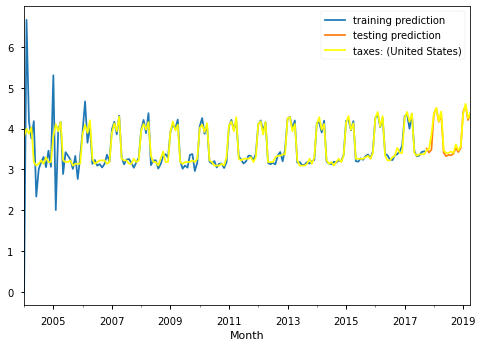

Training RMSE =  0.4413957180223421
Testing RMSE =  0.10039332998576188


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:             taxes: (United States)   No. Observations:                  165
Model:             SARIMAX(1, 2, 2)x(4, 2, 2, 12)   Log Likelihood                 144.246
Date:                            Fri, 23 Jul 2021   AIC                           -268.491
Time:                                    14:56:14   BIC                           -239.146
Sample:                                01-01-2004   HQIC                          -256.566
                                     - 09-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6686      0.233     -2.871      0.004      -1.125      -0.212
ma.L1         -0.4830      0.269     -1.794      0.073      -1.011       0.045
ma.L2         -0.4598      0.301     -1.530      0.126      -1.049       0.129
ar.S.L12      -0.4187      0.821     -0.510      0.610      -2.027       1.190
ar.S.L24      -0.4208      0.366     -1.151      0.250      -1.138       0.296
ar.S.L36      -0.3520      0.277     -1.273      0.203      -0.894       0.190
ar.S.L48      -0.1608      0.217     -0.741      0.459      -0.586       0.265
ma.S.L12      -0.9869      0.765     -1.290      0.197      -2.486       0.512
ma.S.L24       0.1809      0.822      0.220      0.826      -1.430       1.792
sigma2         0.0053      0.001      4.273      0.000       0.003       0.008
===================================================================================
Ljung-Box (L1) (Q):                   0.74   Jarque-Bera (JB):                 0.41
Prob(Q):                              0.39   Prob(JB):                         0.81
Heteroskedasticity (H):               0.64   Skew:                             0.12
Prob(H) (two-sided):                  0.13   Kurtosis:                         2.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax2 = SARIMAX(log_full_train, exog=None, order=(1, 2, 2), seasonal_order=(4, 2, 2, 12)).fit()
evaluate_model(sarimax2, log_taxes, log_full_train, log_holdout)

# Additional Resources

* Modeling cheat sheet: https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/
* AutoARIMA: https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd
* SARIMAX Project walkthrough: https://towardsdatascience.com/newyork-taxi-demand-forecasting-with-sarimax-using-weather-data-d46c041f3f9c